# Task 3
## Image classification with transfer
### Human face emotions classification (part of affectnet dataset, contains 8 classes: neutral, happy, sad, surprise, fear, disgust, anger, contempt) (emotions_ds.zip)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import copy

In [2]:
data_transforms = {
    'train_class': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val_class': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/Colab Notebooks/Vladislav Zmiy - emotions_ds'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train_class', 'val_class']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True)
              for x in ['train_class', 'val_class']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train_class', 'val_class']}
class_names = image_datasets['train_class'].classes


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(base_model, criterion_loss, optimizer, num_epochs=5):

  best_model_wts = copy.deepcopy(base_model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0

    train_acc = 0
    test_acc = 0

    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-' * 10)

    base_model.train()

    for img, labels in dataloaders['train_class']:
      img, labels = img.cuda(), labels.cuda()
      img = img.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      output = base_model(img)
      loss = criterion_loss(output, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * img.size(0)
      _, pred = torch.max(output, dim=1)
      correct_tensor = pred.eq(labels.data.view_as(pred))
      accuracy = torch.mean(correct_tensor.type(torch.cuda.FloatTensor))
      train_acc += accuracy.item() * img.size(0)
    
    base_model.eval()

    for img, labels in dataloaders['val_class']:
      img, labels = img.cuda(), labels.cuda()
      img = img.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      output = base_model(img)
      loss = criterion_loss(output, labels)
      loss.backward()
      optimizer.step()
      test_loss += loss.item() * img.size(0)
      _, pred = torch.max(output, dim=1)
      correct_tensor = pred.eq(labels.data.view_as(pred))
      accuracy = torch.mean(correct_tensor.type(torch.cuda.FloatTensor))
      test_acc += accuracy.item() * img.size(0)
    
    train_loss = train_loss / len(dataloaders['train_class'].dataset)
    test_loss = test_loss / len(dataloaders['val_class'].dataset)

    train_acc = train_acc / len(dataloaders['train_class'].dataset)
    test_acc = test_acc / len(dataloaders['val_class'].dataset)

    print(f'     Training Loss: {train_loss:.4f}, Training Accuracy: {100 * train_acc:.2f}')
    print(f'     Testing Loss: {test_loss:.4f}, Testing Accuracy: {100 * test_acc:.2f}')

  if test_acc > best_acc:
    best_acc = test_acc
    best_model_wts = copy.deepcopy(base_model.state_dict())
    
  print(f'\nBest test Acc: {best_acc:.4f}')

  base_model.load_state_dict(best_model_wts)
  return base_model


## Download model

In [4]:
model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

n_classes = 8
n_inputs = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
                      nn.Linear(n_inputs, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),                   
                      nn.LogSoftmax(dim=1))

if torch.cuda.is_available():
    model.cuda()

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

## Train model

In [6]:
model = train_model(model, criterion, optimizer)

Epoch 1/5
----------
     Training Loss: 1.9001, Training Accuracy: 26.90
     Testing Loss: 1.9476, Testing Accuracy: 24.20
Epoch 2/5
----------
     Training Loss: 1.8950, Training Accuracy: 26.52
     Testing Loss: 1.9205, Testing Accuracy: 25.57
Epoch 3/5
----------
     Training Loss: 1.8868, Training Accuracy: 26.82
     Testing Loss: 1.8975, Testing Accuracy: 26.52
Epoch 4/5
----------
     Training Loss: 1.8874, Training Accuracy: 27.21
     Testing Loss: 1.8956, Testing Accuracy: 26.60
Epoch 5/5
----------
     Training Loss: 1.8862, Training Accuracy: 27.59
     Testing Loss: 1.8907, Testing Accuracy: 27.77

Best test Acc: 0.2777


In [9]:
def predict():
  test_acc = 0
  test_acc = 0
  real_lab = torch.tensor([]).to(device)
  pred_lab = torch.tensor([]).to(device)
  tr_pred =  []

  for batch, (X, y) in enumerate(dataloaders['val_class']):
    X, y = X.to(device), y.to(device)
    real_lab = torch.cat((real_lab, y), 0)
    pred = model(X)
    _, pred = torch.max(pred, dim=1)
    pred_lab = torch.cat((pred_lab, pred), 0)
    
    correct_tensor = pred.eq(y.data.view_as(pred))
    accuracy = torch.mean(correct_tensor.type(torch.cuda.FloatTensor))
    test_acc += accuracy.item()* X.size(0)
    
  test_acc = test_acc / len(dataloaders['val_class'].dataset)
  print(f'    Testing Accuracy: { test_acc:.2f}')
  return pred_lab.cpu().numpy(),  real_lab.cpu().numpy()

all_pr,  real_lab = predict()

    Testing Accuracy: 0.30


## Plot ROC curve for implemented models

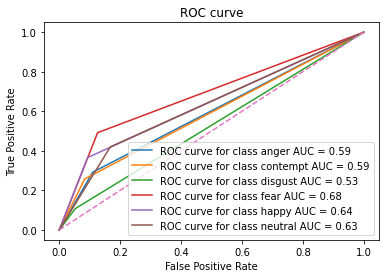

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
lab_plt = [(real_lab == i).astype(float) for i in range(6)]
outs_plt = [(all_pr == i).astype(float) for i in range(6)]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(lab_plt[i], outs_plt[i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.title('ROC curve')
for i in range(6):
  plt.plot(fpr[i], tpr[i], label = f'ROC curve for class {class_names[i]} AUC = {roc_auc[i]:.2f}' )
plt.legend(loc = 'best')
plt.plot([0,1], [0,1], linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Display precision, recall, f1-score metrics for each class (classification report)

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
print(classification_report(real_lab,all_pr, target_names=class_names))


              precision    recall  f1-score   support

       anger       0.28      0.29      0.28       500
    contempt       0.31      0.26      0.28       500
     disgust       0.23      0.11      0.15       500
        fear       0.36      0.49      0.41       500
       happy       0.36      0.37      0.36       500
     neutral       0.26      0.42      0.32       500
         sad       0.28      0.28      0.28       500
    surprise       0.33      0.21      0.26       504

    accuracy                           0.30      4004
   macro avg       0.30      0.30      0.29      4004
weighted avg       0.30      0.30      0.29      4004



## Visualize model prediction

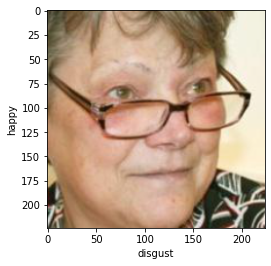

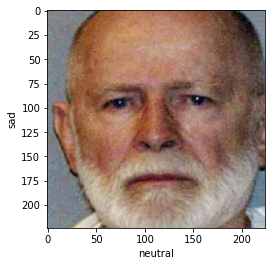

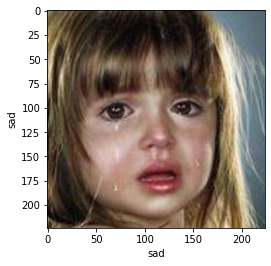

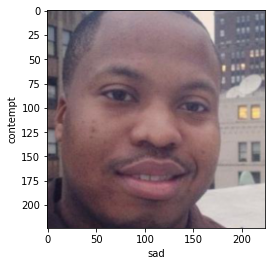

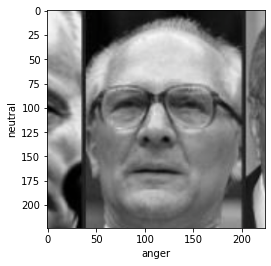

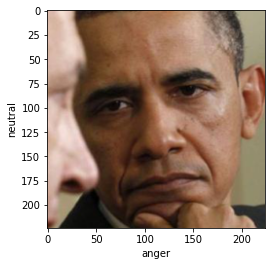

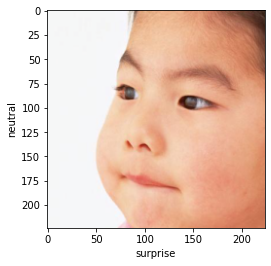

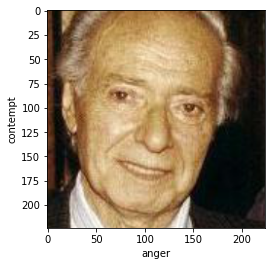

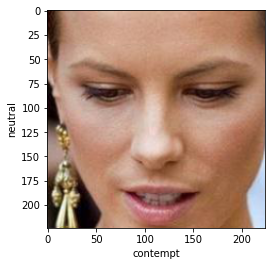

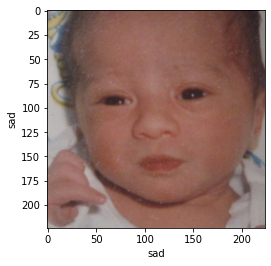

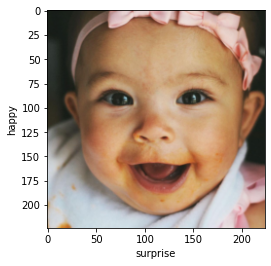

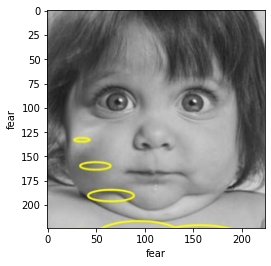

In [13]:
def plot_img(n):
  count = 0
  for img, lab in dataloaders['val_class']:
    count += 1 
    image = img 
    img = img.to(device)
    pred = model(img)
    _, pred = torch.max(pred, dim=1)
    for i in range(4):
      inp = torchvision.utils.make_grid(image[i]).numpy().transpose((1, 2, 0))
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      inp = std * inp + mean
      inp = np.clip(inp, 0, 1)
      plt.imshow(inp)
      plt.ylabel(class_names[lab[i]])
      plt.xlabel(class_names[pred[i]])
      plt.show()
    if count == n:
      break

plot_img(3)

# My opinion 

#### When we tested the model, we got a fairly low accuracy of 30% on average. In my opinion, this is not related to the model itself, but to the data on which the model was trained and tested. Namely, the problem is that each person expresses his emotions in his own way and the model cannot clearly recognize the emotion in the photo. I believe that if you change the dataset, ie add clearer images, you can get more accuracy of this model.